In [46]:
# Setup
import matplotlib
import numpy as np
import scipy as sp
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import ggplot
%matplotlib inline

In [47]:
# Start an inference server

from venture.shortcuts import *
v = make_church_prime_ripl()
# x = Puma().make_church_prime_ripl()

In [48]:
# Forget everything

v.clear()

In [49]:
# # Specify model 1

# v.assume("offset_1", "(uniform_continuous -1 1)")
# v.assume("offset_2", "(uniform_continuous -1 1)")
# v.assume("linear", "(flip 0.5)")
# v.assume("beta_1", "(if linear (uniform_continuous -1 1) 0)")
# v.assume("quadratic", "(flip 0.5)")
# v.assume("beta_2", "(if quadratic (uniform_continuous -1 1) 0)")
# v.assume("noise_sd", "(exp (normal 0 2))")

# v.assume("f_1", "(lambda (x) (+ offset_1 (* beta_1 x) (* beta_2 x x)))")
# v.assume("f_2", "(lambda (x) (+ offset_2 (* beta_1 x) (* beta_2 x x)))")

# v.assume("cluster_membership", "(mem (lambda (index) (if (flip) 1 2)))")

# v.assume("f", "(lambda (x index) (if (eq (cluster_membership index) 1) (f_1 x) (f_2 x)))")

In [50]:
# Specify model 2

# v.assume("cluster_membership_crp", "(make_sym_dir_mult 1 2)")
v.assume("cluster_membership_crp", "(make_crp 0.3)")
v.assume("cluster_membership", "(mem (lambda (index) (cluster_membership_crp)))")
# v.assume("cluster_membership", "(mem (lambda (index) (if (flip) 0 1)))")

v.assume("offset", "(mem (lambda (cluster_index) (uniform_continuous -20 50)))")
v.assume("beta", "(normal 3.4830 3.8094)")
v.assume("noise_sd", "(+ 0.1 (exp (normal 0 2)))")

v.assume("f", "(lambda (x index) (+ (offset (cluster_membership index)) (* beta x)))")

'<procedure>'

In [51]:
v.sample('(cluster_membership 0)')

1

In [52]:
# Start inference

# v.start_continuous_inference()

In [53]:
# Create data

X_1 = np.random.gamma(1, 1, 20)
Y_1 = -0.2 + 0.5 * X_1 + 0.0 * X_1 * X_1
Y_1 += 0.1 * np.random.randn(*X_1.shape)

X_2 = np.random.gamma(1, 1, 10)
Y_2 = +0.2 + 0.5 * X_2
Y_2 += 0.1 * np.random.randn(*X_2.shape)

X_3 = np.random.gamma(1, 1, 25)
Y_3 = +0.7 + 0.5 * X_3
Y_3 += 0.1 * np.random.randn(*X_3.shape)

X = np.concatenate((X_1, X_2, X_3))
Y = np.concatenate((Y_1, Y_2, Y_3))

In [54]:
# Read in CSV data

mydata = pd.read_csv("for_python.csv", header=0) #python starts counting at zero
X = mydata['mynewdata.FAI']
Y = mydata['mynewdata.AQ']


In [55]:
# Observe data

for index, (x, y) in enumerate(zip(X, Y)):
    v.observe("(normal (f %f %d) noise_sd)" % (x, index), y)
    index += 1

In [56]:
# v.sample("(cluster_membership 0)")

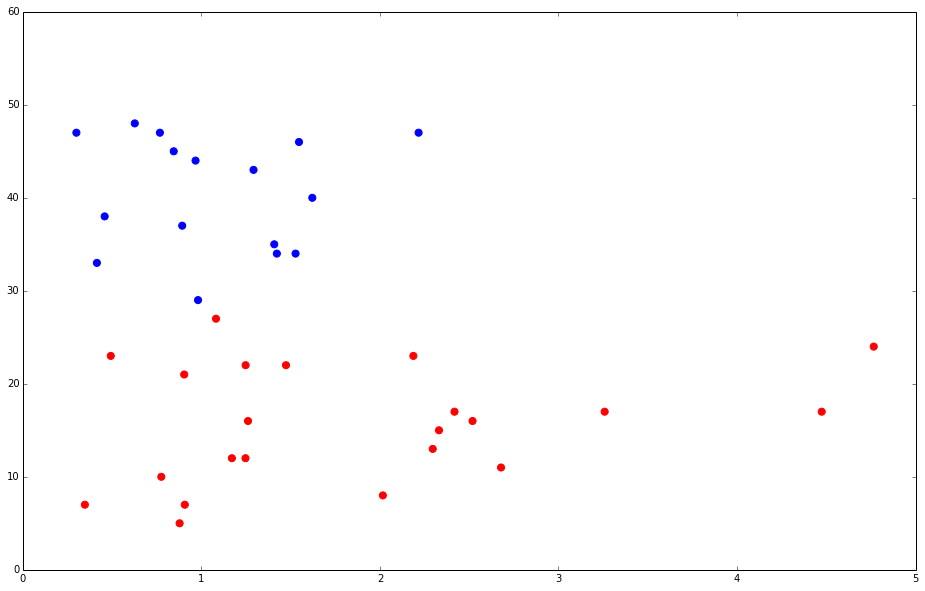

In [57]:
# Sample the parameters and draw a picture

# Only necessary if not running continuous inference
v.infer(5000)

# sample = v.sample("(list offset_1 offset_2 beta_1 beta_2 noise_sd)")
# offset_1 = sample[0]
# offset_2 = sample[1]
# beta_1 = sample[2]
# beta_2 = sample[3]
# noise_sd = sample[4]

# beta = v.sample("beta_1")
# offset_1 = v.sample("(offset 0)")
# offset_2 = v.sample("(offset 1)")

fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')
cluster_numbers = np.unique(cluster_memberships)
canonical_cluster_memberships = np.zeros(len(cluster_memberships))
for i, value in enumerate(cluster_numbers):
    canonical_cluster_memberships[cluster_memberships==value] = i
cluster_memberships = canonical_cluster_memberships

for (cluster_index, x, y) in zip(cluster_memberships, X, Y):
#     cluster_index = v.sample("(cluster_membership %d)" % index)
#     y_hat = v.sample("(f (0 0))")# % (x, index))
#     print(cluster_index)
    if cluster_index == 0:
        color = 'b'
    elif cluster_index == 1:
        color = 'r'
    elif cluster_index == 2:
        color = 'm'
    elif cluster_index == 3:
        color = 'c'
    else:
        color = 'k'
    plt.scatter(x, y, color=color, s=50)

# plt.scatter(X, Y, color='r', s=50)
# plt.scatter(X_2, Y_2, color='b', s=50)
# plot_x = np.linspace(min(X), max(X), 100)
# # plt.plot(plot_x, offset_1 + beta * plot_x, ls='-', color='g', lw=5)
# # plt.plot(plot_x, offset_2 + beta * plot_x, ls='-', color='g', lw=5)

# plt.show()

In [58]:
cluster_memberships

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.])

In [59]:
# # Sample in a loop to get distribution

# samples = list()

# for i in range(100):
    
# #     print(i)
    
#     v.infer(50)

#     sample = v.sample("(list offset beta_1 beta_2 noise_sd linear quadratic)")
#     offset = sample[0]
#     beta_1 = sample[1]
#     beta_2 = sample[2]
#     noise_sd = sample[3]
#     linear = sample[4]
#     quadratic = sample[5]
    
#     samples.append(linear)
    
# fig, ax = plt.subplots(figsize=(16, 10))
# plt.clf()

# plt.hist(samples)

# plt.show()

In [60]:
# Stop inference

# v.stop_continuous_inference()

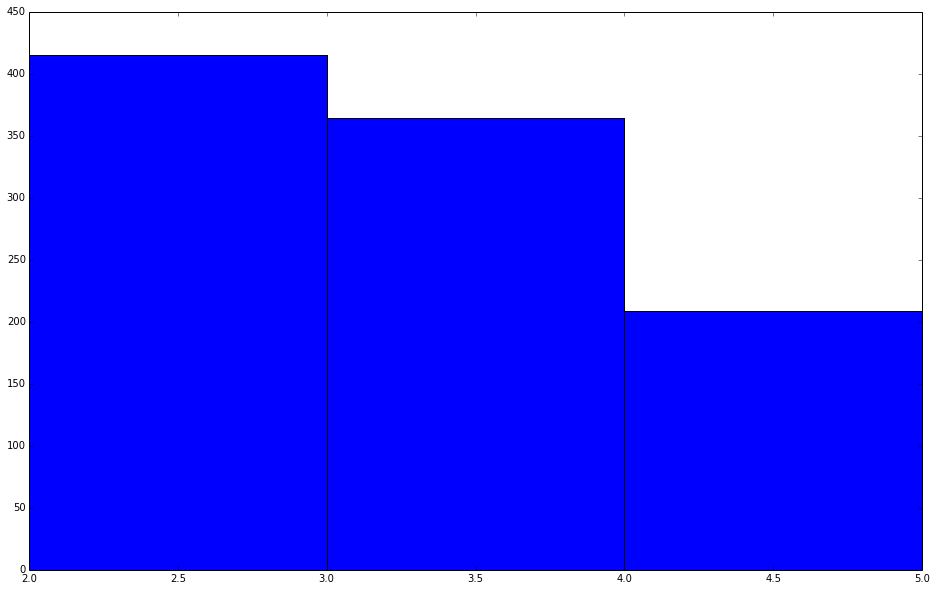

In [202]:
# Sample the parameters and draw a picture

samples = list()

for _ in range(1000):

    v.infer(1000)

    cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                       for index in range(len(X))) + ')')
    cluster_numbers = np.unique(cluster_memberships)
    
    samples.append(len(cluster_numbers))
    
    
fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

plt.hist(samples, bins=[0,1,2,3,4,5]) # Pyplot does dumb things with bins when left alone.

plt.show()

Saving 6.0 x 4.0 in image.


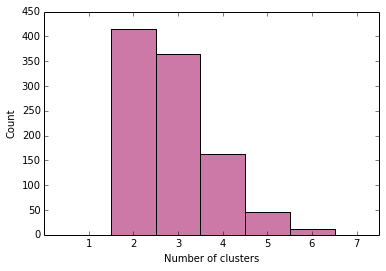

<ggplot: (8790973085061)>


In [203]:
# ggplot
# Relies on list of samples generated from for loop above

df = pd.DataFrame(samples,  columns=['cluster_num_count'])

# subtract 0.5 from all values to center
df['cluster_num_count'] = df['cluster_num_count']-0.5

p = ggplot.ggplot(ggplot.aes(x='cluster_num_count'), data=df)
p = (p + ggplot.geom_histogram(binwidth=1, fill='#CC79A7') + ggplot.theme_matplotlib() + ggplot.xlim(0,(max(df['cluster_num_count'])+1)) + 
ggplot.scale_x_continuous(breaks = range(1,10)) + ggplot.xlab("Number of clusters") + ggplot.ylab("Count"))



ggplot.ggsave(p, "cluster_num_hist.pdf")
print(p)

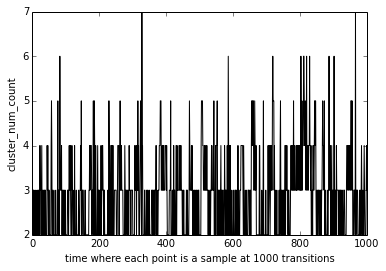

<ggplot: (8790975697001)>


In [204]:
# Try to get a "trace" of number of clusters
df = pd.DataFrame(samples,  columns=['cluster_num_count'])

t = range(1,1001)

df['t'] = t

# print(df)

trace = ggplot.ggplot(ggplot.aes(x='t', y='cluster_num_count'), data=df)
trace = (trace + ggplot.geom_line()+ ggplot.theme_matplotlib() + 
ggplot.xlab("time where each point is a sample at 1000 transitions"))

print(trace)


          ACF  lagsize
0    0.380438        1
1    0.242274        2
2    0.242790        3
3    0.189090        4
4    0.139953        5
5    0.083485        6
6    0.105234        7
7    0.063007        8
8    0.040381        9
9   -0.001317       10
10   0.043964       11
11   0.053107       12
12   0.012045       13
13   0.042580       14
14  -0.005498       15
15  -0.030156       16
16  -0.017279       17
17  -0.036513       18
18  -0.002421       19
19   0.004854       20
20  -0.010516       21
21  -0.001164       22
22  -0.004044       23
23  -0.053355       24
24  -0.021290       25
25  -0.003351       26
26  -0.009909       27
27   0.041842       28
28   0.080410       29
29   0.062262       30
..        ...      ...
470 -0.024395      471
471 -0.031007      472
472  0.019978      473
473  0.068299      474
474  0.026118      475
475  0.054954      476
476  0.013809      477
477  0.071270      478
478  0.055111      479
479  0.052422      480
480  0.038558      481
481  0.0341

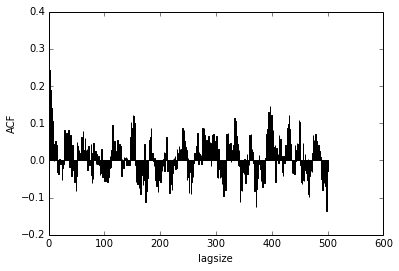

<ggplot: (8790976176901)>
Effective Sample Size
256.901493385


In [205]:
# Autocorrelation

ACF = []
for lag in range(1,501):
    result = []
    for row in range(lag,1000):
        result.append(df.ix[row,"cluster_num_count"])
    original = samples[:-lag]
    ACF.append(sp.stats.spearmanr(original,result))
    
# Returns a list of tuples of ACF values for lags in range

ACF = [x[0] for x in ACF]

s0 = pd.Series(ACF, name='ACF')

lagsize = range(1,501)
s1 = pd.Series(range(1,501), name='lagsize')

newdf = pd.DataFrame(s0, columns=["ACF"])
newdf['lagsize'] = s1

print(newdf)

x = ggplot.ggplot(ggplot.aes(x='lagsize', y='ACF'), data=newdf)
x = (x + ggplot.geom_bar(stat="bar")+ggplot.theme_matplotlib())

print(x)

# Effective sample size
last_k =[ n for n,i in enumerate(ACF) if i<0.05 ][0]
ACF_k = ACF[0:last_k]
print('Effective Sample Size')
print(1000/(1+(2*sum(ACF_k))))


In [63]:
# Find median of above
np.median(samples)

3.0

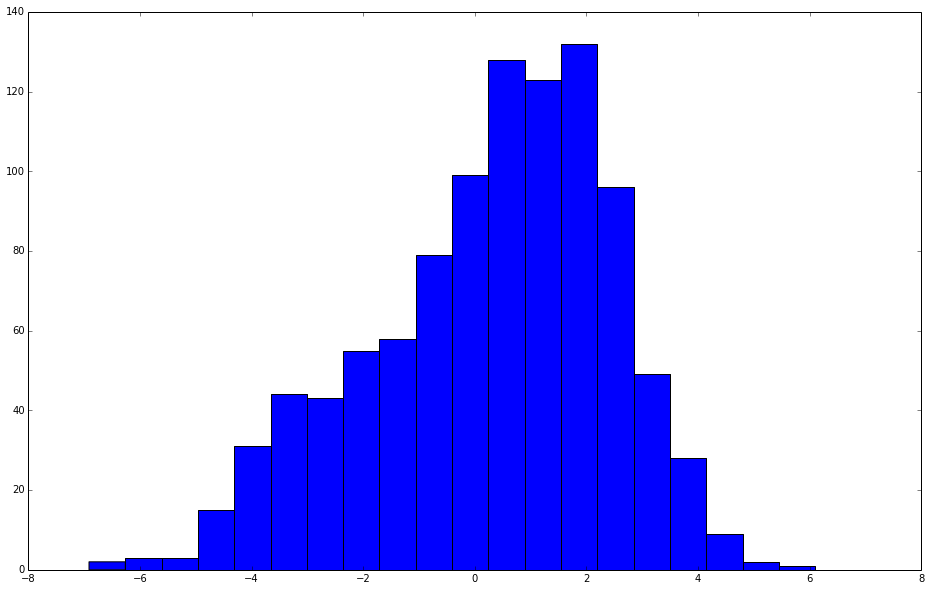

In [188]:
# Sample the parameters and draw a picture

samples = list()

for _ in range(1000):

    v.infer(1000)
    
    param_beta = v.sample('beta')

    samples.append(param_beta)
    
fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

plt.hist(samples, bins=20)

plt.show()

Saving 6.0 x 4.0 in image.


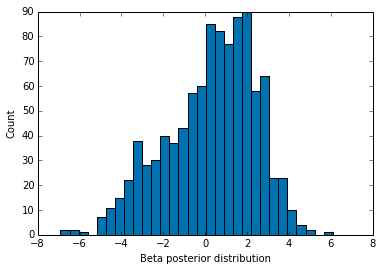

<ggplot: (8790973406097)>


In [189]:
# ggplot
# Relies on list of samples generated from for loop above

df = pd.DataFrame(samples,  columns=['Beta_posterior'])


p = ggplot.ggplot(ggplot.aes(x='Beta_posterior'), data=df)
p = (p + ggplot.geom_histogram(fill='#0072B2') + ggplot.theme_matplotlib() + 
ggplot.xlab("Beta posterior distribution") + ggplot.ylab("Count"))



ggplot.ggsave(p, "beta_posterior_hist.pdf")
print(p)

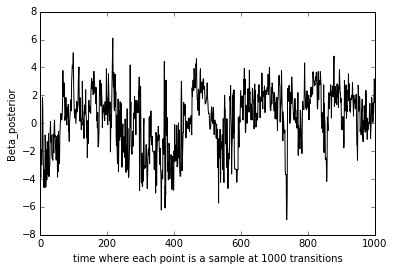

<ggplot: (8790973624733)>


In [190]:
# Try to get a "trace" of beta values

t = range(1,1001)

df['t'] = t


trace = ggplot.ggplot(ggplot.aes(x='t', y='Beta_posterior'), data=df)
trace = (trace + ggplot.geom_line()+ ggplot.theme_matplotlib() + 
ggplot.xlab("time where each point is a sample at 1000 transitions"))

print(trace)



In [191]:
# Sample 95% credible interval for beta values
a = np.percentile(samples, 2.5)
b = np.percentile(samples, 97.5)
print("95% credible interval for beta values")
print(a,b)

# Sample 90% credible interval for beta values
a = np.percentile(samples, 5)
b = np.percentile(samples, 95)
print("90% credible interval for beta values")
print(a,b)

# Sample mean for beta values
c = np.mean(samples)
print("mean of beta values")
print(c)

# Median of beta values
z = np.median(samples)
print("Median of beta values")
print(z)

#Sample standard deviation for beta values
d = np.std(samples)
print("Standard deviation for beta values")
print(d)

# Count values less than 0
f = sum(i < 0 for i in samples)
f = f/1000.
print("posterior falling beneath 0")
print(f)

# Count values greater than 0
g = sum(i > 0 for i in samples)
g = g/1000.
print("posterior falling above 0")
print(g)


95% credible interval for beta values
(-4.250137660060564, 3.7102200481356951)
90% credible interval for beta values
(-3.7039892143361701, 3.2393432379721316)
mean of beta values
0.276417588458
Median of beta values
0.627115285247
Standard deviation for beta values
2.15009499098
posterior falling beneath 0
0.39
posterior falling above 0
0.61


          ACF  lagsize
0    0.750034        1
1    0.654859        2
2    0.566804        3
3    0.537266        4
4    0.497619        5
5    0.490665        6
6    0.465161        7
7    0.462814        8
8    0.458529        9
9    0.420608       10
10   0.397388       11
11   0.376021       12
12   0.353545       13
13   0.317102       14
14   0.328304       15
15   0.341369       16
16   0.330286       17
17   0.323631       18
18   0.316960       19
19   0.297402       20
20   0.302414       21
21   0.299929       22
22   0.287748       23
23   0.306219       24
24   0.311253       25
25   0.290470       26
26   0.298047       27
27   0.284003       28
28   0.277942       29
29   0.271349       30
..        ...      ...
470 -0.082155      471
471 -0.077388      472
472 -0.084437      473
473 -0.079690      474
474 -0.110218      475
475 -0.119020      476
476 -0.145361      477
477 -0.135086      478
478 -0.100939      479
479 -0.086887      480
480 -0.088909      481
481 -0.0904

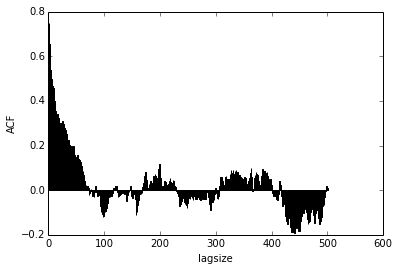

<ggplot: (8790975432881)>


In [201]:
# Autocorrelation

ACF = []
for lag in range(1,501):
    result = []
    for row in range(lag,1000):
        result.append(df.ix[row,"Beta_posterior"])
    original = samples[:-lag]
    ACF.append(sp.stats.pearsonr(original,result))
    
# Returns a list of tuples of ACF values for lags in range

ACF = [x[0] for x in ACF]

s0 = pd.Series(ACF, name='ACF')

lagsize = range(1,501)
s1 = pd.Series(range(1,501), name='lagsize')

newdf = pd.DataFrame(s0, columns=["ACF"])
newdf['lagsize'] = s1

print(newdf)

# Effective sample size
last_k =[ n for n,i in enumerate(ACF) if i<0.05 ][0]
ACF_k = ACF[0:last_k]
print('Effective Sample Size')
print(1000/(1+(2*sum(ACF_k))))



x = ggplot.ggplot(ggplot.aes(x='lagsize', y='ACF'), data=newdf)
x = (x + ggplot.geom_bar(stat="bar")+ggplot.theme_matplotlib())

print(x)

In [67]:
# Sample cluster assignments - make a list of all the assignments for each sample

samples = list()

for _ in range(1000):

    v.infer(10000)
    
    cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')

    cluster_numbers = np.unique(cluster_memberships)

    canonical_cluster_memberships = np.zeros(len(cluster_memberships))
    
    for i, value in enumerate(cluster_numbers):
        canonical_cluster_memberships[cluster_memberships==value] = i
    
    cluster_memberships = canonical_cluster_memberships

    
    samples.append(cluster_memberships)
    
samples = np.array(samples)

# print(samples)

# print(samples.shape) # check to see whether array is correct shape

cluster_labels = np.unique(samples)

co_occurrence_matrix = np.zeros((samples.shape[1], samples.shape[1]))

for label in cluster_labels:
    co_occurrence_matrix += np.dot((samples.T == label) * 1, (samples == label) * 1)
    

# Reshape co-occurence_matrix by linkage
reshaped = sch.linkage(co_occurrence_matrix)
    
# print(co_occurrence_matrix)
# print(co_occurrence_matrix.shape)

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# ax.imshow(co_occurrence_matrix, interpolation='nearest') #interpolation changes fuzzyness. try 'none' or 'nearest'
# plt.show()

KeyboardInterrupt: 

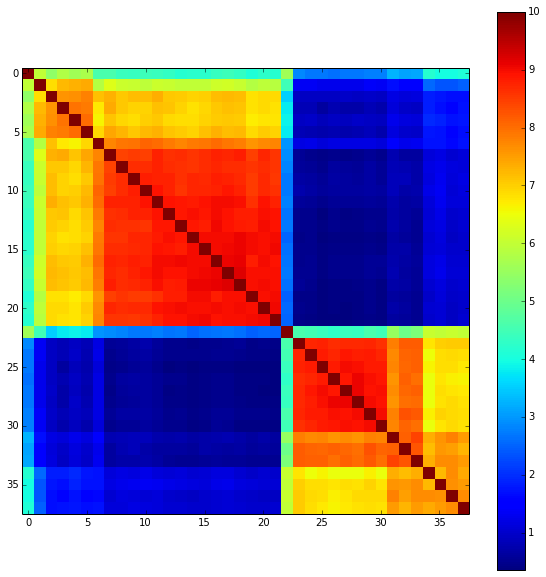

In [68]:
co_occurrence_matrix = np.divide(co_occurrence_matrix, 10)

# Reshape co-occurence_matrix by linkage
linkage = sch.linkage(co_occurrence_matrix)
dendrogram_right = sch.dendrogram(linkage, orientation='right')
dendrogram = sch.dendrogram(linkage)
idx1 = dendrogram_right['leaves']
idx2 = dendrogram['leaves']
co_occurrence_matrix = co_occurrence_matrix[idx1,:]
co_occurrence_matrix = co_occurrence_matrix[:,idx2]

# Co-occurrence matrix figure

plt.clf()
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
map=ax.imshow(co_occurrence_matrix, interpolation='nearest')
plt.colorbar(map)
plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
plt.show()

# print(reshaped)
# reshaped.shape

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# ax.imshow(reshaped, interpolation='nearest') 
# plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
# plt.show()
